In [1]:
import pandas as pd 
import numpy as np
import pandasql as ps
import os
import random 
import numpy as np
import warnings
import tensorflow as tf 
from preprocess_days_stats import preprocess_cumulative_stats, preprocess_match_days
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score
from preprocess_features import preprocess_columns, preprocess_columns_with_odds
from tensorflow.keras import layers
from helper_functions_tensorflow import CSVLoggerCallback, CSVLoggerCallbackParams, plot_loss_curve
from imblearn.over_sampling import RandomOverSampler

# Ignora tutti i warning temporaneamente
warnings.filterwarnings("ignore")


df_giornate = preprocess_match_days(r"c:\Users\Hp\Documents\Serie_A_dump\csv_serie_a")
df_giornate

Reading file: I1 (0).csv
Reading file: I1 (1).csv
Reading file: I1 (10).csv
Reading file: I1 (11).csv
Reading file: I1 (12).csv
Reading file: I1 (13).csv
Reading file: I1 (14).csv
Reading file: I1 (15).csv
Reading file: I1 (16).csv
Reading file: I1 (17).csv
Reading file: I1 (18).csv
Reading file: I1 (2).csv
Reading file: I1 (3).csv
Reading file: I1 (4).csv
Reading file: I1 (5).csv
Reading file: I1 (6).csv
Reading file: I1 (7).csv
Reading file: I1 (8).csv
Reading file: I1 (9).csv
preprocessing finished!


,div,giornata,stagione,date,hometeam,awayteam,ft_home_goals,ft_away_goals,ft_result,ht_home_goals,...,away_fouls,home_corners,away_corners,home_yellow,away_yellow,home_red,away_red,home_win_odds,draw_odds,away_win_odds
0,I1,1,2005/2006,2005-08-27,Fiorentina,Sampdoria,2.0,1.0,H,2.0,...,23.0,9.0,3.0,1.0,4.0,0.0,0.0,2.20,2.87,3.25
1,I1,1,2005/2006,2005-08-27,Livorno,Lecce,2.0,1.0,H,1.0,...,21.0,9.0,2.0,2.0,3.0,0.0,0.0,1.90,2.90,4.00
2,I1,1,2005/2006,2005-08-28,Ascoli,Milan,1.0,1.0,D,0.0,...,16.0,0.0,5.0,2.0,1.0,0.0,0.0,7.50,3.75,1.40
3,I1,1,2005/2006,2005-08-28,Inter,Treviso,3.0,0.0,H,1.0,...,20.0,6.0,1.0,1.0,3.0,0.0,0.0,1.16,5.50,13.00
4,I1,1,2005/2006,2005-08-28,Juventus,Chievo,1.0,0.0,H,1.0,...,12.0,6.0,2.0,1.0,2.0,0.0,0.0,1.25,5.00,13.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6955,I1,12,2023/2024,2023-11-12,Fiorentina,Bologna,2.0,1.0,H,1.0,...,15.0,0.0,3.0,2.0,2.0,0.0,0.0,2.00,3.40,3.80
6956,I1,12,2023/2024,2023-11-12,Inter,Frosinone,2.0,0.0,H,1.0,...,16.0,9.0,4.0,0.0,1.0,0.0,0.0,1.18,8.00,13.00
6957,I1,12,2023/2024,2023-11-12,Lazio,Roma,0.0,0.0,D,0.0,...,13.0,4.0,1.0,3.0,4.0,0.0,0.0,3.00,3.00,2.63
6958,I1,12,2023/2024,2023-11-12,Napoli,Empoli,0.0,1.0,A,0.0,...,13.0,8.0,3.0,1.0,1.0,0.0,0.0,1.22,7.00,11.00


# Capiamo la precisione da battere

In [2]:
conditions_1 = [
      ( (df_giornate[f'home_win_odds'] <= df_giornate['draw_odds']) & (df_giornate[f'home_win_odds'] <= df_giornate[f'away_win_odds'] )), 
      ( (df_giornate['draw_odds'] <= df_giornate[f'away_win_odds']) & (df_giornate['draw_odds'] <= df_giornate[f'home_win_odds'] )), 
      ( (df_giornate[f'away_win_odds'] <= df_giornate['draw_odds']) & (df_giornate[f'away_win_odds'] <= df_giornate[f'home_win_odds'] ))
      ]
values=['H','D','A']

precision = len(np.select(conditions_1, values)[df_giornate[f'ft_result']==np.select(conditions_1, values)])/len(df_giornate) 
precision

0.5451149425287356

La precisione da battere è 55.6%

# Salviamo i risultati della baseline in un csv

In [3]:
import csv

# Nome del file CSV
nome_file = "results/baseline_KNN.csv"

# Apri il file CSV in modalità scrittura
with open(nome_file, mode='w', newline='') as file_csv:
    # Creazione dell'oggetto writer
    writer = csv.writer(file_csv)

    # Scrivi l'intestazione nel file CSV
    writer.writerow(['giorni_cumulativi', 'vanumero_colonne', 'oversample', 'vicini', 'val_accuracy', 'train_accuracy'])

# KNN baseline

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score
from preprocess_features import preprocess_columns

for giorni_cumulativi in range(10):
    giorni_cumulativi = giorni_cumulativi+1
    df_Serie_A_days, stats_teams_serie_A = preprocess_cumulative_stats(dataframe=df_giornate, giorni_cumulativi=giorni_cumulativi)
    for numero_colonne in ['all','less','few']:    
        for oversample in [True, False]:
            (X_train_norm, X_valid_norm, X_test_norm, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
               X_train_df, X_valid_df, X_test_df, Train_labels, Valid_labels, Test_labels) = preprocess_columns(
                df_Serie_A_days,numero_colonne,giorni_cumulativi, oversample=oversample)

            best_accuracy=0
            for vicini in range(3,40): #prendiamo diversi numeri di vicini possibili
                knn_model = KNeighborsClassifier(n_neighbors=3*vicini) #addestriamo il modello con questo numero di vicini 
                knn_model.fit(X_train_norm, Train_labels_encoded) 
                y_valid = knn_model.predict(X_valid_norm)
                val_accuracy = round(accuracy_score(Valid_labels_encoded, y_valid),2)
                y_train = knn_model.predict(X_train_norm)
                train_accuracy = round(accuracy_score(Train_labels_encoded, y_train),2)

                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    
                    # Scrivi i dati nel file CSV
                    with open(nome_file, mode='a', newline='') as file_csv:
                        writer = csv.writer(file_csv)
                        writer.writerow([giorni_cumulativi, numero_colonne, oversample, vicini*3, val_accuracy, train_accuracy])            

preprocess finished
utilizzando tutte le features
utilizzando tutte le features
utilizzando meno features
utilizzando meno features
utilizzando poche features
utilizzando poche features
preprocess finished
utilizzando tutte le features
utilizzando tutte le features
utilizzando meno features
utilizzando meno features
utilizzando poche features
utilizzando poche features
preprocess finished
utilizzando tutte le features
utilizzando tutte le features
utilizzando meno features
utilizzando meno features
utilizzando poche features
utilizzando poche features
preprocess finished
utilizzando tutte le features
utilizzando tutte le features
utilizzando meno features
utilizzando meno features
utilizzando poche features
utilizzando poche features
preprocess finished
utilizzando tutte le features
utilizzando tutte le features
utilizzando meno features
utilizzando meno features
utilizzando poche features
utilizzando poche features
preprocess finished
utilizzando tutte le features
utilizzando tutte le

In [13]:
baseline_KNN_df = pd.read_csv(r'results/baseline_KNN.csv').sort_values(['oversample','val_accuracy'],ascending=[False,False])
baseline_KNN_df.head(8)

,giorni_cumulativi,vanumero_colonne,oversample,vicini,val_accuracy,train_accuracy
362,10,less,True,105,0.47,0.47
7,1,all,True,99,0.46,0.47
19,1,less,True,78,0.46,0.48
31,1,few,True,60,0.46,0.49
126,4,less,True,114,0.46,0.46
303,9,all,True,84,0.46,0.47
345,10,all,True,81,0.46,0.48
6,1,all,True,72,0.45,0.47


In [15]:
baseline_KNN_df = pd.read_csv(r'results/baseline_KNN.csv').sort_values(['oversample','val_accuracy'],ascending=[True,False])
baseline_KNN_df.head(8)

,giorni_cumulativi,vanumero_colonne,oversample,vicini,val_accuracy,train_accuracy
36,1,few,False,45,0.51,0.52
203,6,less,False,105,0.51,0.51
26,1,less,False,84,0.50,0.51
35,1,few,False,39,0.50,0.52
48,2,all,False,72,0.50,0.51
59,2,less,False,42,0.50,0.51
81,3,all,False,114,0.50,0.50
143,4,few,False,96,0.50,0.50


# Dense neural network

In [37]:
import tensorflow as tf 

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            monitor='val_loss',
                                            save_best_only=True) # save only the best model to file

## Iniziamo con poche features e 3 giorni cumulativi

In [2]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

In [17]:
def create_and_compile_dense(num_dense_layers, first_dropout, other_dropouts, first_num_neurons,
                              other_num_neurons, input_shape, first_activation='relu', other_activations='relu'):

    inputs = layers.Input(shape=(input_shape,))
    x = layers.Dense(first_num_neurons, activation=first_activation)(inputs)
    x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
    for i in range(num_dense_layers-1):
        x = layers.Dense(other_num_neurons, activation=other_activations)(x)
        x = layers.Dropout(other_dropouts)(x) 
    outputs = layers.Dense(3, activation='softmax')(x)
    dense_model = tf.keras.Model(inputs, outputs, name='model_1_dense')

    # compilo il modello 
    dense_model.compile(
        loss='sparse_categorical_crossentropy',
        metrics = 'accuracy',
        optimizer = tf.keras.optimizers.Adam()
    )

    return dense_model

In [7]:
for giorni_cumulativi in [5]:
    # calcolo il dataframe con i giorni cumulativi 
    df_Serie_A_days, stats_teams_serie_A = preprocess_cumulative_stats(dataframe=df_giornate, giorni_cumulativi=giorni_cumulativi)
    print(f'giorni cumulativi: {giorni_cumulativi}')
    # seleziono il numero di features da usare nel modello 
    for numero_colonne in ['all','less','few']:
        print(f'numero colonne: {numero_colonne}')    
        X_train_norm, X_valid_norm, X_test_norm, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded = preprocess_columns(
            df_Serie_A_days,numero_colonne,giorni_cumulativi)
        input_shape = X_train_norm.shape[1]
        # fast preprocessing 
        X_train_norm = tf.data.Dataset.from_tensor_slices((X_train_norm, Train_labels_encoded))
        X_valid_norm = tf.data.Dataset.from_tensor_slices((X_valid_norm, Valid_labels_encoded))
        X_train_norm = X_train_norm.batch(32).prefetch(tf.data.AUTOTUNE) #Autotune è per dirgli di prefetchare tanti dati quanti può
        X_valid_norm = X_valid_norm.batch(32).prefetch(tf.data.AUTOTUNE)
        #iniziamo a creare i modelli 
        for num_dense_layers in [2,3,4]:
            for first_dropout in [0.0, 0.2, 0.4, 0.6]:
                for other_dropouts in [0.0, 0.2, 0.4, 0.6]:
                    for first_num_neurons in [32,64,128]:
                        for other_num_neurons in [8, 16, 32]:
                            other_activations = 'relu'
                            first_activation = 'relu'
                            model_1 = create_and_compile_dense(num_dense_layers, first_dropout, other_dropouts, first_num_neurons,
                                    other_num_neurons, input_shape, first_activation, other_activations)

                                # fitto il modello 
                            model_1.fit(
                                    x = X_train_norm,
                                    epochs = 15,
                                    verbose=0,
                                    validation_data = X_valid_norm,
                                    callbacks = [
                                        CSVLoggerCallbackParams('results.csv','model_1_dense', num_dense_layers, first_dropout, other_dropouts, first_num_neurons,
                                                                    other_num_neurons, first_activation, other_activations), 
                                        #create_model_checkpoint(model_name= 'Dense_model_best')
                                                ] 
                                )

preprocess finished
giorni cumulativi: 5
numero colonne: all
utilizzando tutte le features
numero colonne: less
utilizzando meno features
numero colonne: few
utilizzando poche features


In [20]:
df_results_5_days = pd.read_csv(r'C:\Users\Hp\Serie_A\results_5_days.csv', header=None)
df_results_1_2_4 = pd.read_csv(r'C:\Users\Hp\Serie_A\results_1_2_4.csv', header=None)
df_results =pd.concat([df_results_5_days,df_results_1_2_4],ignore_index=True)
df_results.columns = ['experiment', 'num_dense_layers', 'first_dropout', 'other_dropouts', 'first_num_neurons',
                                    'other_num_neurons', 'first_activation', 'other_activations', 'epoch',
                                    'loss', 'accuracy','val_loss','val_accuracy']
df_results.sort_values(['val_loss'], inplace=True)
df_results.head(3)

,experiment,num_dense_layers,first_dropout,other_dropouts,first_num_neurons,other_num_neurons,first_activation,other_activations,epoch,loss,accuracy,val_loss,val_accuracy
22671,model_1_dense,3,0.2,0.0,32,8,relu,relu,13,0.960349,0.539939,0.982211,0.535714
22670,model_1_dense,3,0.2,0.0,32,8,relu,relu,11,0.969211,0.537220,0.982554,0.537088
22669,model_1_dense,3,0.2,0.0,32,8,relu,relu,10,0.968809,0.538409,0.983473,0.535714


### il modello denso migliore 

giorni =5, colonne = less, val_loss: 0.9921 - val_accuracy: 0.5247

giorni = 2, colonne = few, val_loss: 0.9895 - val_accuracy: 0.5220

In [ ]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

giorni_cumulativi = 2
# calcolo il dataframe con i giorni cumulativi 
df_Serie_A_days, stats_teams_serie_A = preprocess_cumulative_stats(dataframe=df_giornate, giorni_cumulativi=giorni_cumulativi)

#scelgo le colonne che voglio usare
numero_colonne = 'less'
print(f'numero colonne: {numero_colonne}')    
(X_train_norm, X_valid_norm, X_test_norm, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
               X_train_df, X_valid_df, X_test_df, Train_labels, Valid_labels, Test_labels) = preprocess_columns(
                                                                                        df_Serie_A_days,numero_colonne,giorni_cumulativi, oversample=False)
input_shape = X_train_norm.shape[1]

# fast preprocessing 
Dataset_train_norm = tf.data.Dataset.from_tensor_slices((X_train_norm, Train_labels_encoded))
Dataset_valid_norm = tf.data.Dataset.from_tensor_slices((X_valid_norm, Valid_labels_encoded))
Dataset_train_norm = Dataset_train_norm.batch(128).prefetch(tf.data.AUTOTUNE) #Autotune è per dirgli di prefetchare tanti dati quanti può
Dataset_valid_norm = Dataset_valid_norm.batch(128).prefetch(tf.data.AUTOTUNE)

#creo e compilo il modello 
model_1 = create_and_compile_dense(num_dense_layers=3, first_dropout=0.2, other_dropouts=0.0, first_num_neurons=32,
                            other_num_neurons=8, input_shape=input_shape, first_activation='relu', other_activations='relu')

# fitto il modello 
history_1 = model_1.fit(
                x = Dataset_train_norm,
                epochs = 15,
                verbose = 1,
                batch_size = 128,
                validation_data = Dataset_valid_norm,
                callbacks = [
                                #CSVLoggerCallbackParams('results.csv','model_1_dense', num_dense_layers, first_dropout, other_dropouts, first_num_neurons,
                                #                other_num_neurons, first_activation, other_activations), 
                                create_model_checkpoint(model_name= 'Dense_model_best') 
                            ] 
                )

### VAlutiamo il modello

In [46]:
model_1 = tf.keras.models.load_model(r'C:\Users\Hp\Serie_A\model_experiments\Dense_model_best')
model_1.evaluate(X_valid_norm, Valid_labels_encoded)

23/23 [==============================] - 0s 1ms/step - loss: 0.9900 - accuracy: 0.5247


[0.9899528622627258, 0.5247252583503723]

0

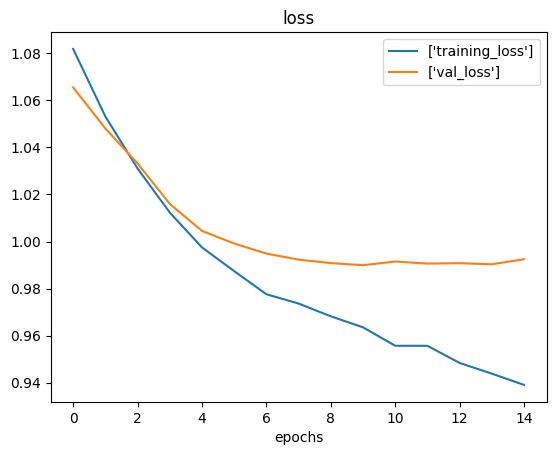

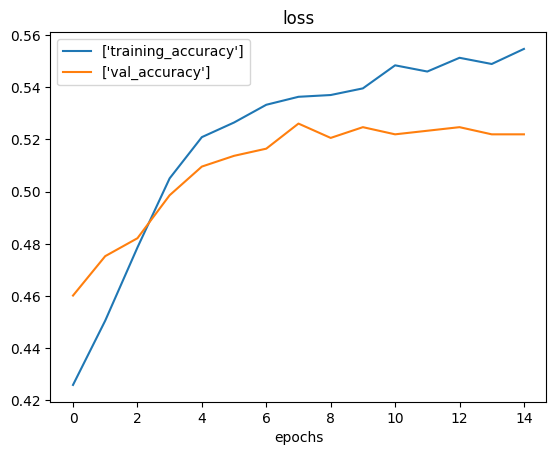

In [47]:
plot_loss_curve(history_1)

Si nota un po' di overfitting nel nostro modelo

In [48]:
result_df = pd.merge(X_valid_df, df_giornate, how='inner', on=['stagione', 'awayteam','hometeam']).reset_index()
len(result_df), len(result_df['stagione'])

(728, 728)

In [49]:
# Visualizziamo un po' di risultati 
model_1_pred_probs = model_1.predict(X_valid_norm)
model_1_prob = model_1.predict(X_valid_norm).max(axis=1)
model_1_predictions = model_1_pred_probs.argmax(axis=1)
model_1_compare = pd.DataFrame({
                                'stagione': list( result_df['stagione'] ),
                                'hometeam': list( result_df['hometeam'] ),
                                'awayteam': list( result_df['awayteam'] ),
                                'preds': model_1_predictions, 
                                'result': Valid_labels, 
                                'pred_prob': model_1_prob,
                                'home_win_odds': list( result_df['home_win_odds'] ),
                                'draw_odds': list( result_df['draw_odds'] ),
                                'away_win_odds': list( result_df['away_win_odds'])
                                })
model_1_compare['snai_pred'] = np.argmin(result_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)
model_1_compare['snai_prob'] = np.nanmin(result_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)

# Assegno ai valori encoded dei valori più comprensibili per vittoria pareggio sconfitta
conditions = [
(model_1_compare['preds'] == 2),  # Condizione per Home Win
(model_1_compare['preds'] == 1),  # Condizione per Away Win
(model_1_compare['preds'] == 0)   # Condizione per Draw
]
conditions_snai = [
(model_1_compare['snai_pred'] == 0),  # Condizione per Home Win
(model_1_compare['snai_pred'] == 2),  # Condizione per Away Win
(model_1_compare['snai_pred'] == 1)   # Condizione per Draw
]

# Valori corrispondenti alle condizioni
values = ['W', 'L', 'D']

# Creazione della nuova colonna 'result' e 'points
model_1_compare['preds'] = np.select(conditions, values)
model_1_compare['snai_pred'] = np.select(conditions_snai, values)
model_1_compare['is_correct'] = model_1_compare['preds'] == model_1_compare['result']

len(model_1_compare)

23/23 [==============================] - 0s 864us/step


728

In [51]:
# Visualizziamo i risultati più regenti 
model_1_compare.sort_values(['stagione'], ascending = False).head(10)

,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct
6897,2023/2024,Frosinone,Fiorentina,L,D,0.398243,3.75,3.60,1.95,L,1.95,False
6932,2023/2024,Lecce,Torino,L,L,0.427992,2.75,3.00,2.80,W,2.75,True
6871,2023/2024,Inter,Milan,W,W,0.517370,2.15,3.50,3.40,W,2.15,True
6884,2023/2024,Sassuolo,Juventus,L,W,0.600415,4.00,4.00,1.80,L,1.80,False
6845,2023/2024,Roma,Salernitana,W,D,0.630786,1.53,4.00,6.50,W,1.53,False
6913,2023/2024,Inter,Bologna,W,D,0.657057,1.36,5.50,7.50,W,1.36,False
6886,2023/2024,Bologna,Napoli,L,D,0.486598,3.75,3.60,1.91,L,1.91,False
6903,2023/2024,Atalanta,Juventus,L,D,0.477075,2.50,3.40,2.80,W,2.50,False
6896,2023/2024,Verona,Atalanta,L,L,0.472274,4.20,3.75,1.83,L,1.83,True
6875,2023/2024,Frosinone,Sassuolo,L,W,0.359327,2.80,3.40,2.50,L,2.50,False


In [58]:
# Visualizziamo i nostri riusltati corretti e quelli sbagliati della snai 
model_1_compare[(model_1_compare['is_correct']) & (model_1_compare['result']!=model_1_compare['snai_pred'])].head(10)

,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct
6353,2021/2022,Napoli,Milan,L,L,0.356057,2.05,3.30,3.60,W,2.05,True
5964,2020/2021,Milan,Napoli,L,L,0.358076,2.55,3.30,2.80,W,2.55,True
2211,2010/2011,Udinese,Roma,L,L,0.465828,2.20,3.20,3.40,W,2.20,True
2361,2011/2012,Inter,Juventus,L,L,0.416441,2.50,3.20,2.88,W,2.50,True
413,2006/2007,Empoli,Palermo,W,W,0.373913,3.10,3.00,2.40,L,2.40,True
5623,2019/2020,Bologna,Sassuolo,L,L,0.379678,2.25,3.50,3.00,W,2.25,True
3859,2015/2016,Frosinone,Empoli,W,W,0.420594,3.00,3.30,2.40,L,2.40,True
1372,2008/2009,Atalanta,Roma,W,W,0.454483,3.60,3.25,2.10,L,2.10,True
4536,2016/2017,Palermo,Genoa,W,W,0.466695,5.00,4.00,1.67,L,1.67,True
6549,2022/2023,Fiorentina,Lazio,L,L,0.435927,2.40,3.50,2.80,W,2.40,True


In [61]:
# visualizziamo i risultati più sbagliati
model_1_compare[(~model_1_compare['is_correct'])].sort_values(['pred_prob'], ascending=False).head(10)

,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct
362,2005/2006,Inter,Siena,W,D,0.810917,1.40,4.00,9.00,W,1.40,False
1794,2009/2010,Juventus,Siena,W,D,0.803054,1.36,4.50,9.00,W,1.36,False
2236,2010/2011,Juventus,Catania,W,D,0.799998,1.44,4.20,7.50,W,1.44,False
2177,2010/2011,Napoli,Brescia,W,D,0.788951,1.36,4.33,10.00,W,1.36,False
624,2006/2007,Inter,Udinese,W,D,0.781283,1.33,4.50,9.50,W,1.33,False
1105,2007/2008,Napoli,Siena,W,D,0.775727,1.95,2.75,5.25,W,1.95,False
4479,2016/2017,Inter,Sampdoria,W,L,0.771817,1.33,5.50,9.00,W,1.33,False
6754,2022/2023,Napoli,Verona,W,D,0.762938,1.53,4.00,6.50,W,1.53,False
1350,2008/2009,Juventus,Cagliari,W,L,0.755631,1.36,4.50,9.00,W,1.36,False
6294,2021/2022,Milan,Spezia,W,L,0.742436,1.33,5.00,9.50,W,1.33,False


Si vede che molti errori sono dati da squadre blasonate che giocano in casa

# CONV1D model

In [198]:
def create_and_compile_conv_1d(num_conv_layers, first_dropout, other_dropouts, first_filters_num, first_kernel_size,
                               other_num_filters, other_kernel_sizem, input_shape, dense_neurons, first_activation='relu', other_activations='relu'):
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Reshape((input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.Conv1D(filters=first_filters_num, kernel_size=first_kernel_size, activation=first_activation)(x)
    x = layers.Dropout(first_dropout)(x) 
    for i in range(num_conv_layers-1):
        x = layers.Conv1D(filters=other_num_filters, kernel_size=other_kernel_sizem, activation=first_activation)(x)
        x = layers.Dropout(other_dropouts)(x) 
    x = layers.Flatten()(x)
    x = layers.Dense(dense_neurons)(x)
    x = layers.Dropout(other_dropouts)(x) 
    outputs = layers.Dense(3, activation='softmax')(x)
    conv_model = tf.keras.Model(inputs, outputs, name='model_1_dense')

    # compilo il modello 
    conv_model.compile(
        loss='sparse_categorical_crossentropy',
        metrics = 'accuracy',
        optimizer = tf.keras.optimizers.Adam()
    )

    return conv_model

In [196]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

giorni_cumulativi = 3
# calcolo il dataframe con i giorni cumulativi 
df_Serie_A_days, stats_teams_serie_A = preprocess_cumulative_stats(dataframe=df_giornate, giorni_cumulativi=giorni_cumulativi)

#scelgo le colonne che voglio usare
numero_colonne = 'less'
print(f'numero colonne: {numero_colonne}')    
(X_train_norm, X_valid_norm, X_test_norm, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
               X_train_df, X_valid_df, X_test_df, Train_labels, Valid_labels, Test_labels) = preprocess_columns(
                                                                                        df_Serie_A_days,numero_colonne,giorni_cumulativi, oversample=False)
input_shape = X_train_norm.shape[1]

# fast preprocessing 
Dataset_train_norm = tf.data.Dataset.from_tensor_slices((X_train_norm, Train_labels_encoded))
Dataset_valid_norm = tf.data.Dataset.from_tensor_slices((X_valid_norm, Valid_labels_encoded))
Dataset_train_norm = Dataset_train_norm.batch(32).prefetch(tf.data.AUTOTUNE) #Autotune è per dirgli di prefetchare tanti dati quanti può
Dataset_valid_norm = Dataset_valid_norm.batch(32).prefetch(tf.data.AUTOTUNE)

#creo e compilo il modello 
model_2 = create_and_compile_conv_1d(num_dense_layers=3, first_dropout=0.2, other_dropouts=0.0,
                            other_num_neurons=8, input_shape=input_shape, first_activation='relu', other_activations='relu')

# fitto il modello 
history_2 = model_2.fit(
                x = Dataset_train_norm,
                epochs = 15,
                verbose = 1,
                validation_data = Dataset_valid_norm,
                callbacks = [
                                #CSVLoggerCallbackParams('results.csv','model_1_dense', num_dense_layers, first_dropout, other_dropouts, first_num_neurons,
                                #                other_num_neurons, first_activation, other_activations), 
                                #create_model_checkpoint(model_name= 'CONV1D_model_best') 
                            ] 
                )

preprocess finished
numero colonne: less
utilizzando meno features
Epoch 1/15
184/184 [==============================] - 22s 118ms/step - loss: 1.0252 - accuracy: 0.4935 - val_loss: 1.0026 - val_accuracy: 0.5124
Epoch 2/15
184/184 [==============================] - 21s 116ms/step - loss: 0.9929 - accuracy: 0.5190 - val_loss: 1.0034 - val_accuracy: 0.5055
Epoch 3/15
184/184 [==============================] - 21s 115ms/step - loss: 0.9856 - accuracy: 0.5309 - val_loss: 1.0043 - val_accuracy: 0.5247
Epoch 4/15
184/184 [==============================] - 21s 112ms/step - loss: 0.9824 - accuracy: 0.5309 - val_loss: 1.0015 - val_accuracy: 0.5151
Epoch 5/15
184/184 [==============================] - 21s 112ms/step - loss: 0.9796 - accuracy: 0.5345 - val_loss: 1.0052 - val_accuracy: 0.5179
Epoch 6/15
184/184 [==============================] - 20s 111ms/step - loss: 0.9807 - accuracy: 0.5308 - val_loss: 1.0040 - val_accuracy: 0.5151
Epoch 7/15
184/184 [==============================] - 20s 108ms

# Unisco il modello dense che ho creato sopra con uno che tenga conto delle quote 

In [2]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

giorni_cumulativi = 2
# calcolo il dataframe con i giorni cumulativi 
df_Serie_A_days, stats_teams_serie_A = preprocess_cumulative_stats(dataframe=df_giornate, giorni_cumulativi=giorni_cumulativi)

#scelgo le colonne che voglio usare
numero_colonne = 'less'
print(f'numero colonne: {numero_colonne}')    
(X_train_norm, X_valid_norm, X_test_norm, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
    X_train_df, X_valid_df, X_test_df, Train_labels, Valid_labels, Test_labels,Train_odds_df,Valid_odds_df,Train_odds_df) = preprocess_columns_with_odds(
                                                                                        df_Serie_A_days,numero_colonne,giorni_cumulativi, oversample=False)
input_shape = X_train_norm.shape[1]

# fast preprocessing 
Dataset_train_norm = tf.data.Dataset.from_tensor_slices((X_train_norm, Train_labels_encoded))
Dataset_valid_norm = tf.data.Dataset.from_tensor_slices((X_valid_norm, Valid_labels_encoded))
Dataset_train_norm = Dataset_train_norm.batch(128).prefetch(tf.data.AUTOTUNE) #Autotune è per dirgli di prefetchare tanti dati quanti può
Dataset_valid_norm = Dataset_valid_norm.batch(128).prefetch(tf.data.AUTOTUNE)

preprocess finished
numero colonne: less
utilizzando meno features


KeyError: "['home_win_odds', 'draw_odds', 'away_win_odds'] not found in axis"

In [11]:
Train_odds_df

,home_win_odds,draw_odds,away_win_odds
4446,3.40,3.25,2.25
2969,1.91,3.60,3.75
599,1.53,3.40,6.00
3273,3.30,3.20,2.25
6822,1.83,3.80,4.00
...,...,...,...
2400,2.00,3.30,3.75
2071,1.80,3.40,4.60
4802,4.33,3.60,1.85
2182,2.75,3.10,2.63


In [ ]:
#creo e compilo il modello 
model_1_dense = create_and_compile_dense(num_dense_layers=3, first_dropout=0.2, other_dropouts=0.0, first_num_neurons=32,
                            other_num_neurons=8, input_shape=input_shape, first_activation='relu', other_activations='relu')

In [ ]:
# fitto il modello 
history_1 = model_1.fit(
                x = Dataset_train_norm,
                epochs = 15,
                verbose = 1,
                batch_size = 128,
                validation_data = Dataset_valid_norm,
                callbacks = [
                                #CSVLoggerCallbackParams('results.csv','model_1_dense', num_dense_layers, first_dropout, other_dropouts, first_num_neurons,
                                #                other_num_neurons, first_activation, other_activations), 
                                create_model_checkpoint(model_name= 'Dense_model_best') 
                            ] 
                )